In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import psycopg2
import pandas as pd
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Configuration details for connecting to the PostgreSQL database
db_config = {
    "dbname": "Idmp",       # Name of the database
    "user": "postgres",     # Username for the database
    "password": "Mahaveer@2002", # Password for the database
    "host": "localhost",    # Host where the database is running          
}

# SQL queries to select all data from various tables in the database
branded_food = "SELECT * FROM branded_food"
food = "SELECT * FROM food"
food_attribute = "SELECT * FROM food_attribute"
food_attribute_type = "SELECT * FROM food_attribute_type"
food_nutrient = "SELECT * FROM food_nutrient"
food_update_log_entry = "SELECT * FROM food_update_log_entry"
measure_unit = "SELECT * FROM measure_unit"
microbe = "SELECT * FROM microbe"
nutrient = "SELECT * FROM nutrient"
nutrient_incoming_name = "SELECT * FROM nutrient_incoming_name"

try:
    # Establishing a connection to the PostgreSQL database using psycopg2
    conn = psycopg2.connect(**db_config)

    # Executing SQL queries and loading the results into pandas DataFrames
    branded_food = pd.read_sql_query(branded_food, conn)               # Fetch all rows from 'branded_food' table
    food = pd.read_sql_query(food, conn)                               # Fetch all rows from 'food' table
    food_attribute = pd.read_sql_query(food_attribute, conn)           # Fetch all rows from 'food_attribute' table
    food_attribute_type = pd.read_sql_query(food_attribute_type, conn) # Fetch all rows from 'food_attribute_type' table
    food_nutrient = pd.read_sql_query(food_nutrient, conn)             # Fetch all rows from 'food_nutrient' table
    food_update_log_entry = pd.read_sql_query(food_update_log_entry, conn) # Fetch all rows from 'food_update_log_entry' table
    measure_unit = pd.read_sql_query(measure_unit, conn)               # Fetch all rows from 'measure_unit' table
    microbe = pd.read_sql_query(microbe, conn)                         # Fetch all rows from 'microbe' table
    nutrient = pd.read_sql_query(nutrient, conn)                       # Fetch all rows from 'nutrient' table
    nutrient_incoming_name = pd.read_sql_query(nutrient_incoming_name, conn) # Fetch all rows from 'nutrient_incoming_name' table

    # Closing the database connection
    conn.close()

except Exception as e:
    # Catching and printing any errors that occur during database connection or query execution
    print(f"An error occurred: {e}")

In [5]:
# Merging the 'food' and 'branded_food' tables on the 'fdc_id' column to combine relevant data
# Selecting specific columns: 'fdc_id', 'description', 'ingredients', and 'branded_food_category'
data_food = food.merge(branded_food, on='fdc_id')[['fdc_id', 'description', 'ingredients', 'branded_food_category']]

# Merging the 'food_nutrient' and 'nutrient' tables to combine nutrient-related data
# Joining on 'nutrient_id' from 'food_nutrient' and 'id' from 'nutrient'
# Selecting specific columns: 'fdc_id', 'nutrient_id', and 'name' (nutrient name)
food_nutrients_combined = food_nutrient.merge(nutrient, left_on='nutrient_id', right_on='id')[['fdc_id', 'nutrient_id', 'name']]

# Merging the combined nutrient data with the combined food data on 'fdc_id'
# This creates a dataset that includes food details along with their nutrient information
data = food_nutrients_combined.merge(data_food, on='fdc_id')

### 1. **`preprocess_data(data, data_count)`**:
   - **Purpose**: Cleans and prepares the data for analysis. It limits the dataset to the first `data_count` rows, processes nutrients by combining and cleaning them, and removes duplicates and unnecessary columns like `nutrient_id` and `name`.
   - **Use**: Prepares the dataset by simplifying nutrient data and ensuring no redundancy, making it suitable for further processing.

In [6]:
def preprocess_data(data, data_count):
    # Limit the data to the first 'data_count' rows
    data = data[:data_count]

    # Combine nutrient names for each 'fdc_id' by grouping and joining them into a single string
    data['nutrients'] = data.groupby('fdc_id')['name'].transform(lambda x: ' '.join(x)) 

    # Remove duplicate nutrient names within each 'fdc_id' by splitting, finding unique values, and rejoining as a string
    data['nutrients'] = data['nutrients'].transform(lambda x: np.unique(x.split(' '))) 

    # Clean up the 'nutrients' column by removing unwanted characters like commas, parentheses, and plus signs
    data['nutrients'] = data['nutrients'].transform(lambda x: (" ".join(x)).replace(",", " ").replace("(", " ").replace(")", " ").replace("+", " "))    

    # Drop the columns 'nutrient_id' and 'name' as they are no longer needed
    data = data.drop(['nutrient_id', 'name'], axis=1)

    # Remove duplicate rows from the dataset
    data = data.drop_duplicates()

    # Return the processed dataset
    return data

### 2. **`text_processing(data)`**:
   - **Purpose**: Standardizes and preprocesses text data (such as descriptions, ingredients, and nutrients). It converts text to lowercase, removes non-alphanumeric characters, and applies stemming to words to reduce them to their base forms.
   - **Use**: Ensures consistency in the text data by removing noise and reducing words to their root form for better model performance.

In [7]:
def text_processing(data):
    # Convert the 'description' column to lowercase
    data['description'] = data['description'].transform(lambda x: x.lower())
    # Convert the 'ingredients' column to lowercase
    data['ingredients'] = data['ingredients'].transform(lambda x: x.lower())
    # Convert the 'nutrients' column to lowercase
    data['nutrients'] = data['nutrients'].transform(lambda x: x.lower())
    # Convert the 'branded_food_category' column to lowercase and store it in 'food_category'
    data['food_category'] = data['branded_food_category'].transform(lambda x: x.lower())

    # Remove non-alphanumeric characters from the 'description' column
    data['description'] = data['description'].transform(lambda x: re.sub(r'[^\w\s]', '', x))
    # Remove non-alphanumeric characters from the 'ingredients' column
    data['ingredients'] = data['ingredients'].transform(lambda x: re.sub(r'[^\w\s]', '', x))
    # Remove non-alphanumeric characters from the 'nutrients' column
    data['nutrients'] = data['nutrients'].transform(lambda x: re.sub(r'[^\w\s]', '', x))
    # Remove non-alphanumeric characters from the 'food_category' column
    data['food_category'] = data['food_category'].transform(lambda x: re.sub(r'[^\w\s]', '', x))

    # Uncomment the line below if the NLTK Punkt tokenizer is not already downloaded
    # nltk.download('punkt')

    # Create a PorterStemmer instance for stemming words
    stemmer = PorterStemmer()

    # Function to tokenize, stem, and rejoin the tokens into a string
    def stem_string(text):
        # Tokenize the input text (convert to lowercase)
        tokens = word_tokenize(text.lower())
        # Stem each token using the PorterStemmer
        stemmed_tokens = [stemmer.stem(token) for token in tokens]
        # Join the stemmed tokens into a single string
        return ' '.join(stemmed_tokens)
        
    # Apply stemming to the 'description' column
    data['description'] = data['description'].apply(stem_string)
    # Apply stemming to the 'ingredients' column
    data['ingredients'] = data['ingredients'].apply(stem_string)
    # Apply stemming to the 'nutrients' column
    data['nutrients'] = data['nutrients'].apply(stem_string)

    # Reset the index of the DataFrame
    data = data.reset_index()
    # Drop the old index column
    data = data.drop('index', axis=1)
    
    # Return the processed DataFrame
    return data

### 3. **`feature_engineering(data)`**:
   - **Purpose**: Transforms raw data into meaningful features for modeling. It encodes the food categories using a `LabelEncoder`, and applies TF-IDF vectorization to the text columns (description, ingredients, and nutrients) to convert them into numerical features.
   - **Use**: Prepares the data for machine learning by converting categorical and text-based features into a format that can be used by models.

In [8]:
def feature_engineering(data):
    # Initialize a LabelEncoder instance to encode categorical labels
    le = LabelEncoder()
    # Encode the 'food_category' column into numeric values and store it in a new column 'food_category_encoded'
    data['food_category_encoded'] = le.fit_transform(data['food_category'])

    # Initialize a TfidfVectorizer with specific parameters:
    # - Stop words are removed ('english')
    # - Maximum of 100 features are retained
    # - Terms must appear in at least 1% (min_df=0.01) and at most 90% (max_df=0.9) of the documents
    vectorizer = TfidfVectorizer(stop_words='english', max_features=100, min_df=0.01, max_df=0.9)

    # Apply TF-IDF vectorization to the 'description' column
    tfidf_matrix_description = vectorizer.fit_transform(data['description'])  
    # Convert the TF-IDF matrix for 'description' into a DataFrame
    tfidf_df_description = pd.DataFrame(
        tfidf_matrix_description.toarray(), 
        columns=vectorizer.get_feature_names_out()
    )
    
    # Apply TF-IDF vectorization to the 'ingredients' column
    tfidf_matrix_ingredients = vectorizer.fit_transform(data['ingredients'])  
    # Convert the TF-IDF matrix for 'ingredients' into a DataFrame
    tfidf_df_ingredients = pd.DataFrame(
        tfidf_matrix_ingredients.toarray(), 
        columns=vectorizer.get_feature_names_out()
    )
    
    # Apply TF-IDF vectorization to the 'nutrients' column
    tfidf_matrix_nutrients = vectorizer.fit_transform(data['nutrients'])  
    # Convert the TF-IDF matrix for 'nutrients' into a DataFrame
    tfidf_df_nutrients = pd.DataFrame(
        tfidf_matrix_nutrients.toarray(), 
        columns=vectorizer.get_feature_names_out()
    )

    # Initialize an empty DataFrame to store the combined features
    df = pd.DataFrame()

    # Concatenate the TF-IDF DataFrames for 'description', 'ingredients', and 'nutrients' along columns
    df = pd.concat([tfidf_df_description, tfidf_df_ingredients, tfidf_df_nutrients], axis=1)
    
    # Add the encoded food category as the target variable to the DataFrame
    df['category'] = data['food_category_encoded']
    
    # Return the feature-engineered DataFrame
    return df

### 4. **`insert_into_db(predictions, data, accuracy)`**:
   - **Purpose**: Inserts the predicted and actual food categories into a database, along with the model's accuracy. This allows tracking of predictions and their corresponding accuracies.
   - **Use**: Saves the model's predictions to a database for future reference or analysis.

In [9]:
def insert_into_db(predictions, data, accuracy):
    # Establish a connection to the database using the provided configuration
    connection = psycopg2.connect(**db_config)

    # Create a cursor object to execute SQL queries
    cursor = connection.cursor()
    
    # Iterate through the actual and predicted values from the predictions DataFrame
    for i, j in zip(predictions['y_test'], predictions['y_pred']):
        # SQL query to insert data into the 'predictions' table
        insert_query = """
                        INSERT INTO predictions (model_name, accuracy, actual_value, predicted_value)
                        VALUES (%s, %s, %s, %s);
                        """
        # Execute the SQL query with parameters:
        # - Model name: "RandomForestClassifier"
        # - Model accuracy: provided accuracy value
        # - Actual value: Retrieve the actual category name based on 'y_test'
        # - Predicted value: Retrieve the predicted category name based on 'y_pred'
        cursor.execute(insert_query, ("RandomForestClassifier", accuracy, 
                                      data[data['food_category_encoded'] == i]['food_category'].values[0], 
                                      data[data['food_category_encoded'] == j]['food_category'].values[0]))

    # Commit the transaction to save changes to the database
    connection.commit()
    # Close the cursor to release database resources
    cursor.close()
    # Close the database connection
    connection.close()

### 5. **`training_model_metrics(df, data)`**:
   - **Purpose**: Splits the data into training and testing sets, trains a `RandomForestClassifier` model on the data, makes predictions, and calculates evaluation metrics like accuracy, precision, and F1 score.
   - **Use**: Trains the machine learning model and evaluates its performance using relevant metrics. These metrics help assess the model's effectiveness.

In [10]:
def training_model_metrics(df, data):
    # Separate the features (X) and target variable (y) from the dataset
    X = df.drop('category', axis=1)  # Features excluding the target variable
    y = df['category']  # Target variable

    # Split the data into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=0.95)  # Retain 95% of the variance
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Initialize the Random Forest Classifier with a fixed random seed for reproducibility
    model = RandomForestClassifier(random_state=42)
    
    # Train the model using the training data
    model.fit(X_train_pca, y_train)

    # Use the trained model to make predictions on the test data
    y_pred = model.predict(X_test_pca)

    # Calculate evaluation metrics for the model
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),  # Accuracy of predictions
        'precision': precision_score(y_test, y_pred, average='weighted'),  # Macro-averaged precision
        'f1_score': f1_score(y_test, y_pred, average='weighted'),  # Weighted F1 score
    }

    # Create a DataFrame to store the actual and predicted values
    predictions = {"y_test": y_test, "y_pred": y_pred}
    predictions = pd.DataFrame(predictions)
    
    # Insert the predictions and metrics into the database
    insert_into_db(predictions, data, metrics['accuracy'])
    
    # Return the calculated metrics
    return metrics

### 6. **`insert_into_metrics(metrics, size)`**:
   - **Purpose**: Inserts the model's performance metrics (accuracy, precision, F1 score) into a database along with the size of the data used for training.
   - **Use**: Tracks and stores the performance of the model for each run in a database, allowing future comparisons or performance tracking.

In [16]:
def insert_into_metrics(metrics, size):
    # Establish a connection to the database using the configuration
    connection = psycopg2.connect(**db_config)
    cursor = connection.cursor()
    
    # SQL query for inserting metrics into the performance_metrics table
    query = """
        INSERT INTO performance_metrics (model_name, accuracy, precision, f1_score, data_size)
        VALUES (%s, %s, %s, %s, %s)
    """
    
    # Execute the query with the provided metrics and size
    cursor.execute(query, (
        "RandomForestClassifier",  # Model name
        round(metrics["accuracy"], 2),   # Rounded accuracy
        round(metrics["precision"], 2), # Rounded precision 
        round(metrics["f1_score"], 2),  # Rounded F1 score
        size                            # Data size
    ))
    
    # Commit the transaction and close the connection
    connection.commit()
    cursor.close()
    connection.close()


### 7. **`run_model(data, data_count)`**:
   - **Purpose**: Orchestrates the entire process of running the model, from preprocessing the data, applying text processing, feature engineering, training the model, and storing the results (predictions and metrics) in the database.
   - **Use**: The main entry point to execute the entire machine learning pipeline, automating data preparation, model training, and result storage.

In [12]:
def run_model(data, data_count):
    # Preprocess the data to filter and clean it up to the given count
    data = preprocess_data(data, data_count)
    
    # Perform text processing on the data to standardize text features
    data = text_processing(data)
    
    # Generate feature representations from the processed data
    df = feature_engineering(data)
    
    # Train the model, evaluate its performance, and insert predictions into the database
    metrics = training_model_metrics(df, data)
    
    # Save the calculated performance metrics into the database
    insert_into_metrics(metrics, df.shape[0])
    return metrics

In [17]:
output = run_model(data, 17000000)

print("Accuracy of the Model: ", round(output['accuracy'] * 100, 2), "%")
print("Precision of the Model: ", round(output['precision'] * 100, 2), "%")
print("F1 Score of the Model: ", round(output['f1_score'] * 100, 2), "%")

Accuracy of the Model:  91.98 %
Precision of the Model:  91.97 %
F1 Score of the Model:  91.87 %


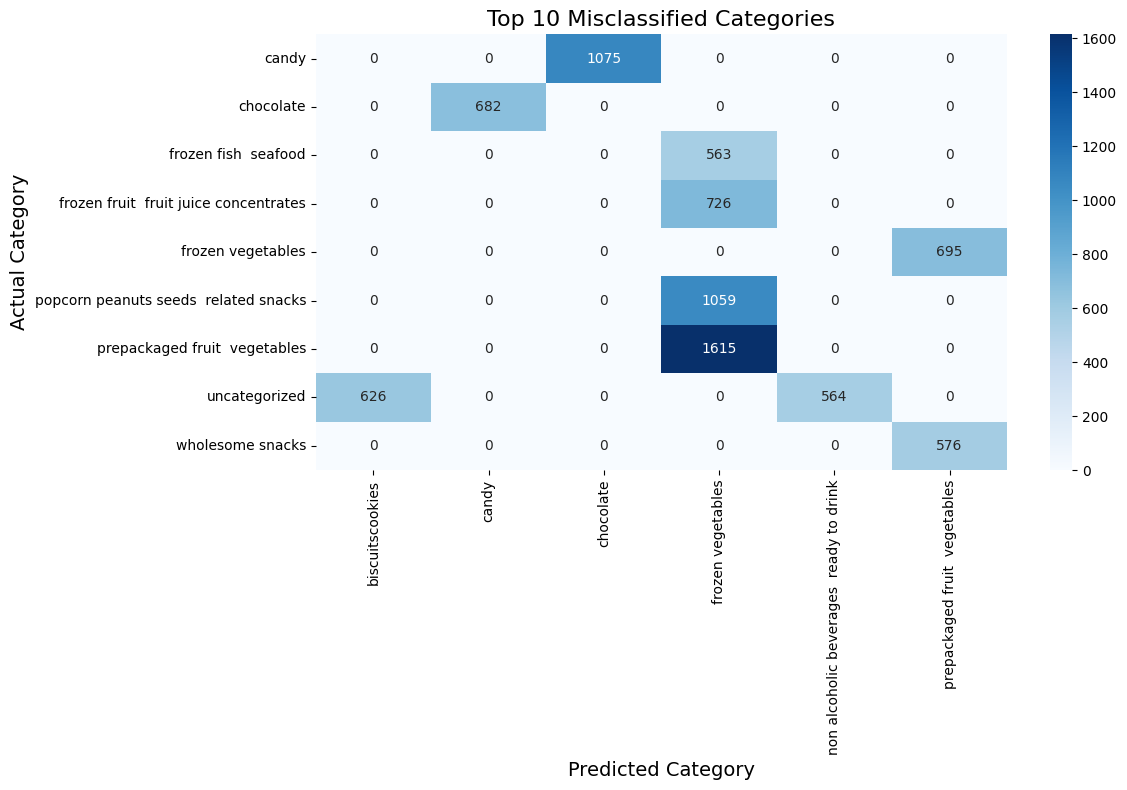

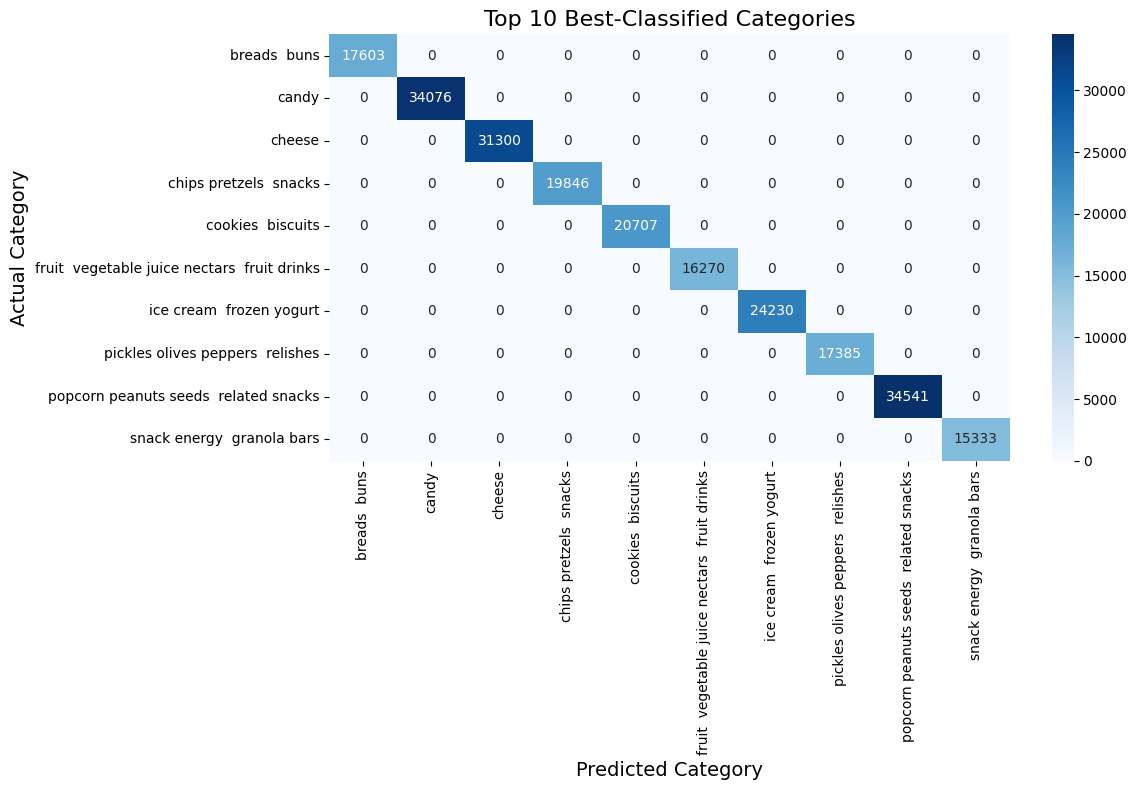

In [13]:
# Database configuration
db_config = {
    "dbname": "Idmp",
    "user": "postgres",
    "password": "Mahaveer@2002",
    "host": "localhost",
}

# Query to fetch data from the predictions table
query = "SELECT actual_value, predicted_value FROM predictions"

try:
    # Connect to the PostgreSQL database
    conn = psycopg2.connect(**db_config)
    
    # Load predictions data into a pandas DataFrame
    predictions_df = pd.read_sql_query(query, conn)
    
    # Close the database connection
    conn.close()

except Exception as e:
    print(f"An error occurred: {e}")

# Compute the count of misclassifications (actual vs predicted values)
misclassifications = (
    predictions_df[predictions_df["actual_value"] != predictions_df["predicted_value"]]
    .groupby(["actual_value", "predicted_value"])
    .size()
    .reset_index(name="count")
)

# Sort by count and select the top 10 most misclassified pairs
top_misclassifications = misclassifications.sort_values(by="count", ascending=False).head(10)

# Create a pivot table for visualization
pivot_data = top_misclassifications.pivot(
    index="actual_value", columns="predicted_value", values="count"
).fillna(0)

# Plot a heatmap for the top 10 best-classified categories
plt.figure(figsize=(12, 8))  # Increase the figure size to avoid overcrowding
sns.heatmap(pivot_data, annot=True, fmt=".0f", cmap="Blues", cbar=True)

# Update x-axis and y-axis labels for better readability
plt.title("Top 10 Misclassified Categories", fontsize=16)
plt.xlabel("Predicted Category", fontsize=14)
plt.ylabel("Actual Category", fontsize=14)
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels vertically for clarity
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Compute the count of correct classifications (actual == predicted)
correct_classifications = (
    predictions_df[predictions_df["actual_value"] == predictions_df["predicted_value"]]
    .groupby(["actual_value", "predicted_value"])
    .size()
    .reset_index(name="count")
)

# Sort by count and select the top 10 best-classified categories
top_correct_classifications = correct_classifications.sort_values(by="count", ascending=False).head(10)

# Create a pivot table for visualization
pivot_data = top_correct_classifications.pivot(
    index="actual_value", columns="predicted_value", values="count"
).fillna(0)

# Plot a heatmap for the top 10 best-classified categories
plt.figure(figsize=(12, 8))  # Increase the figure size to avoid overcrowding
sns.heatmap(pivot_data, annot=True, fmt=".0f", cmap="Blues", cbar=True)

# Update x-axis and y-axis labels for better readability
plt.title("Top 10 Best-Classified Categories", fontsize=16)
plt.xlabel("Predicted Category", fontsize=14)
plt.ylabel("Actual Category", fontsize=14)
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels vertically for clarity
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()
